<a href="https://colab.research.google.com/github/Jay4l44/Task-4-Loan-Approval-Prediction/blob/main/Task_4_Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loan Approval Prediction

## Libraries Used

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore') # To stop future warnings
# Set custom color palette
custom_colors = ['#FFFEFA', '#799CF0', '#FFF6D2', '#132FBA']
sns.set_palette(custom_colors)

print("All libraries imported successfully!")

All libraries imported successfully!


## Dataset

### Import dataset

In [ ]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")
print("Path to dataset files:", path)

# Load the dataset
import os
print("Files in dataset:", os.listdir(path))

# Load the main dataset file
print("\nFiles in the dataset:")
for file in os.listdir(path):
    print(f"- {file}")

# Load the dataset with the correct filename
df = pd.read_csv(os.path.join(path, 'loan_approval_dataset.csv'))
print(f"Dataset loaded successfully!")

100%|██████████| 80.6k/80.6k [00:00<00:00, 519kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/architsharma01/loan-approval-prediction-dataset/versions/1
Files in dataset: ['loan_approval_dataset.csv']

Files in the dataset:
- loan_approval_dataset.csv
Dataset loaded successfully!


### Check data for missing values

In [ ]:
# Display entire dataset
print(f"\nComplete Dataset ({df.shape[0]} rows × {df.shape[1]} columns):")
df

# Check missing data
print("\nMissing Data Analysis:")
missing_data = df.isnull().sum()
print("Missing values per column:")
print(missing_data)

# Show only columns with missing data
missing_cols = missing_data[missing_data > 0]
if len(missing_cols) > 0:
    print(f"\nColumns with missing data:")
    for col, count in missing_cols.items():
        percentage = (count / len(df)) * 100
        print(f"   • {col}: {count} missing ({percentage:.2f}%)")
else:
    print("\nNo missing data found!")


Complete Dataset (4269 rows × 13 columns):

Missing Data Analysis:
Missing values per column:
loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

No missing data found!


## Data Understanding

### Check for imbalance

In [ ]:
print("\nCategorical Features:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

print("\nNumerical Features:")
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_cols)

# Check target variable for imbalance
print("\nTARGET VARIABLE IMBALANCE CHECK:")
target_counts = df[' loan_status'].value_counts()
print("Loan Status distribution:")
print(target_counts)

target_percent = df[' loan_status'].value_counts(normalize=True) * 100
print("\nLoan Status percentages:")
for status, percent in target_percent.items():
    print(f"  {status}: {percent:.2f}%")

# Check if imbalanced (if one class < 40% or > 60%)
minority_percent = min(target_percent.values)
if minority_percent < 40:
    print(f"\nIMBALANCED DATASET DETECTED!")
    print(f"Minority class: {minority_percent:.2f}% - Will need SMOTE!")
else:
    print(f"\nBalanced dataset - no SMOTE needed")


Categorical Features:
[' education', ' self_employed', ' loan_status']

Numerical Features:
['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']

TARGET VARIABLE IMBALANCE CHECK:
Loan Status distribution:
 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

Loan Status percentages:
   Approved: 62.22%
   Rejected: 37.78%

IMBALANCED DATASET DETECTED!
Minority class: 37.78% - Will need SMOTE!


### Visualize the imabalnce

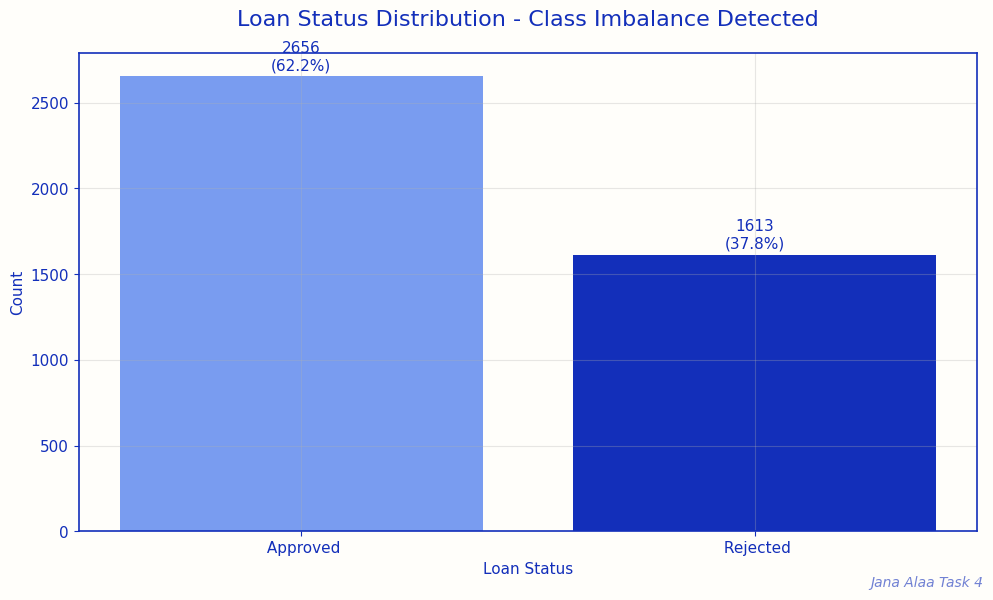

In [ ]:
# Define custom color palette
custom_colors = ['#FFFEFA', '#799CF0', '#FFF6D2', '#132FBA']
accent_color = '#132FBA'

# Set up custom matplotlib parameters
plt.rcParams.update({
    'figure.facecolor': '#FFFEFA',
    'axes.facecolor': '#FFFEFA',
    'axes.edgecolor': accent_color,
    'axes.linewidth': 1.2,
    'text.color': accent_color,
    'axes.labelcolor': accent_color,
    'xtick.color': accent_color,
    'ytick.color': accent_color,
    'font.size': 11,
    'font.weight': 'medium'
})

# Create custom seaborn palette
sns.set_palette(custom_colors)

# Simple visualization
fig, ax = plt.subplots(figsize=(10, 6)) # Create figure and axes objects
target_counts = df[' loan_status'].value_counts()
bars = ax.bar(target_counts.index, target_counts.values, color=['#799CF0', '#132FBA']) # Use ax for plotting

ax.set_title('Loan Status Distribution - Class Imbalance Detected', fontsize=16, pad=20) # Use ax for title
ax.set_xlabel('Loan Status') # Use ax for xlabel
ax.set_ylabel('Count') # Use ax for ylabel
ax.grid(True, alpha=0.3) # Use ax for grid

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 20,f'{int(height)}\n({height/len(df)*100:.1f}%)', ha='center', va='bottom') # Use ax for text

fig.text(0.99, 0.01, 'Jana Alaa Task 4', fontsize=10, alpha=0.6, ha='right', style='italic', color='#132FBA')
plt.tight_layout()
plt.show()

## Data Preprocessing

### Prepare features and variables

In [ ]:
# Separate features and target
print("\nSeparating Features and Target Variable:")

# Create feature matrix (X) - exclude loan_id and target variable
feature_cols = [col for col in df.columns if col not in ['loan_id', ' loan_status']]
X = df[feature_cols].copy()
y = df[' loan_status'].copy()

print(f"Feature matrix X: {X.shape}")
print(f"Target variable y: {y.shape}")
print(f"\nFeatures to use: {feature_cols}")


Separating Features and Target Variable:
Feature matrix X: (4269, 11)
Target variable y: (4269,)

Features to use: [' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']


### Identify features

In [ ]:
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

# Check unique values in categorical features
print("\nCategorical Feature Analysis:")
for col in categorical_features:
    unique_vals = X[col].unique()
    print(f"   • {col}: {unique_vals}")

Categorical features (2): [' education', ' self_employed']
Numerical features (9): [' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']

Categorical Feature Analysis:
   •  education: [' Graduate' ' Not Graduate']
   •  self_employed: [' No' ' Yes']


### Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
X_encoded = X.copy()

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le

    print(f"Encoded {col}:")
    print(f"Original: {X[col].unique()}")
    print(f"Encoded:  {X_encoded[col].unique()}")

print(f"\nAll categorical features encoded successfully!")
print(f"Final feature matrix shape: {X_encoded.shape}")

# Verify no more object types
print(f"\nData types after encoding:")
print(X_encoded.dtypes.value_counts())

Encoded  education:
Original: [' Graduate' ' Not Graduate']
Encoded:  [0 1]
Encoded  self_employed:
Original: [' No' ' Yes']
Encoded:  [0 1]

All categorical features encoded successfully!
Final feature matrix shape: (4269, 11)

Data types after encoding:
int64    11
Name: count, dtype: int64


### Prepare target variable & train-test split

In [ ]:
# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"Target variable encoded:")
print(f"Original: {y.unique()}")
print(f"Encoded:  {np.unique(y_encoded)}")

# Create stratified train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"\nTrain-Test Split Results:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in splits
print(f"\nClass Distribution Check:")
train_dist = np.bincount(y_train) / len(y_train) * 100
test_dist = np.bincount(y_test) / len(y_test) * 100
print(f"Training: {train_dist[0]:.1f}% / {train_dist[1]:.1f}%")
print(f"Test: {test_dist[0]:.1f}% / {test_dist[1]:.1f}%")

Target variable encoded:
Original: [' Approved' ' Rejected']
Encoded:  [0 1]

Train-Test Split Results:
Training set: 3415 samples
Test set: 854 samples

Class Distribution Check:
Training: 62.2% / 37.8%
Test: 62.2% / 37.8%


### Apply SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE (Training):")
unique, counts = np.unique(y_train, return_counts=True)
for i, (label, count) in enumerate(zip(unique, counts)):
    target_name = target_encoder.inverse_transform([label])[0]
    print(f"{target_name}: {count} samples ({count/len(y_train)*100:.1f}%)")

print(f"\nAfter SMOTE (Training):")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for i, (label, count) in enumerate(zip(unique, counts)):
    target_name = target_encoder.inverse_transform([label])[0]
    print(f"   {target_name}: {count} samples ({count/len(y_train_balanced)*100:.1f}%)")

print(f"\nSMOTE Results:")
print(f"Original training size: {X_train.shape[0]}")
print(f"Balanced training size: {X_train_balanced.shape[0]}")
print(f"New samples created: {X_train_balanced.shape[0] - X_train.shape[0]}")

Before SMOTE (Training):
 Approved: 2125 samples (62.2%)
 Rejected: 1290 samples (37.8%)

After SMOTE (Training):
    Approved: 2125 samples (50.0%)
    Rejected: 2125 samples (50.0%)

SMOTE Results:
Original training size: 3415
Balanced training size: 4250
New samples created: 835


## Model Training

### Logistic regression model

In [ ]:
# Train Logistic Regression
print("\nTraining Logistic Regression...")
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_balanced, y_train_balanced)

print("Logistic Regression trained successfully!")

# Train Decision Tree
print("\nTraining Decision Tree...")
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train_balanced, y_train_balanced)

print("Decision Tree trained successfully!")
print(f"\nBoth models trained on {X_train_balanced.shape[0]} balanced samples")


Training Logistic Regression...
Logistic Regression trained successfully!

Training Decision Tree...
Decision Tree trained successfully!

Both models trained on 4250 balanced samples


### Predictions

In [ ]:
# Logistic Regression predictions
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)

# Decision Tree predictions
dt_predictions = dt_model.predict(X_test)
dt_probabilities = dt_model.predict_proba(X_test)

print("Predictions completed for both models!")
print(f"Test set size: {len(X_test)} samples")

# Quick prediction summary
print(f"\nPrediction Summary:")
lr_approved = sum(lr_predictions == 0)
lr_rejected = sum(lr_predictions == 1)
dt_approved = sum(dt_predictions == 0)
dt_rejected = sum(dt_predictions == 1)

print(f"Logistic Regression: {lr_approved} Approved, {lr_rejected} Rejected")
print(f"Decision Tree: {dt_approved} Approved, {dt_rejected} Rejected")

Predictions completed for both models!
Test set size: 854 samples

Prediction Summary:
Logistic Regression: 539 Approved, 315 Rejected
Decision Tree: 529 Approved, 325 Rejected


### Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Logistic Regression Performance
print("\nLOGISTIC REGRESSION PERFORMANCE:")
print("-" * 40)

lr_precision = precision_score(y_test, lr_predictions, average='weighted')
lr_recall = recall_score(y_test, lr_predictions, average='weighted')
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')

print(f"Precision: {lr_precision:.3f}")
print(f"Recall:    {lr_recall:.3f}")
print(f"F1-Score:  {lr_f1:.3f}")

print("\nDetailed Classification:")
print(classification_report(y_test, lr_predictions, target_names=['Approved', 'Rejected']))

# Decision Tree Performance
print("\nDECISION TREE PERFORMANCE:")
print("-" * 40)

dt_precision = precision_score(y_test, dt_predictions, average='weighted')
dt_recall = recall_score(y_test, dt_predictions, average='weighted')
dt_f1 = f1_score(y_test, dt_predictions, average='weighted')

print(f"Precision: {dt_precision:.3f}")
print(f"Recall:    {dt_recall:.3f}")
print(f"F1-Score:  {dt_f1:.3f}")

print("\nDetailed Classification:")
print(classification_report(y_test, dt_predictions, target_names=['Approved', 'Rejected']))

print(f"Performance Comparison:")
print(f"   Logistic Regression - F1: {lr_f1:.3f}, Precision: {lr_precision:.3f}, Recall: {lr_recall:.3f}")
print(f"   Decision Tree       - F1: {dt_f1:.3f}, Precision: {dt_precision:.3f}, Recall: {dt_recall:.3f}")

# Calculate performance difference
improvement = ((dt_f1 - lr_f1) / lr_f1) * 100

print(f"\nDecision Tree Classifier was more accurate!")
print(f"Performance improvement: {improvement:.1f}% better than Logistic Regression")


LOGISTIC REGRESSION PERFORMANCE:
----------------------------------------
Precision: 0.793
Recall:    0.794
F1-Score:  0.793

Detailed Classification:
              precision    recall  f1-score   support

    Approved       0.83      0.84      0.84       531
    Rejected       0.73      0.72      0.72       323

    accuracy                           0.79       854
   macro avg       0.78      0.78      0.78       854
weighted avg       0.79      0.79      0.79       854


DECISION TREE PERFORMANCE:
----------------------------------------
Precision: 0.979
Recall:    0.979
F1-Score:  0.979

Detailed Classification:
              precision    recall  f1-score   support

    Approved       0.98      0.98      0.98       531
    Rejected       0.97      0.98      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

Performance Comparison:
   Logistic Regression -

### Comparison visual

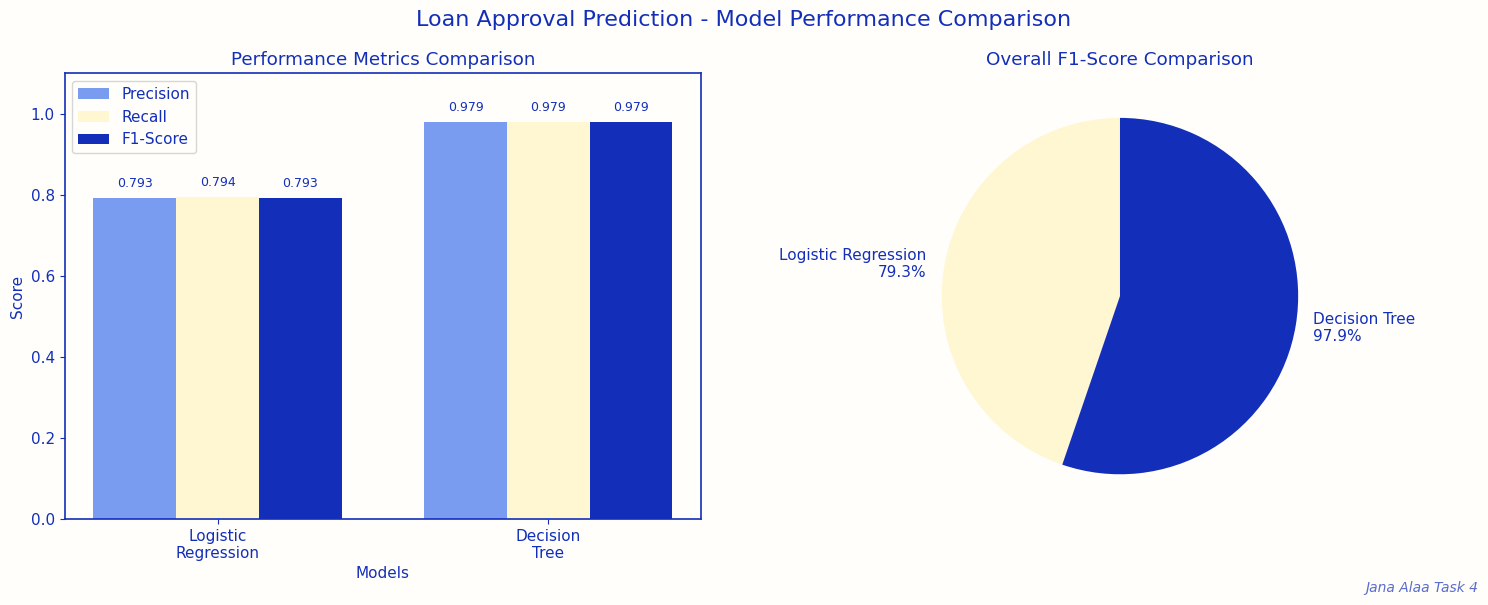

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Loan Approval Prediction - Model Performance Comparison', fontsize=16, color='#132FBA', y=0.98)

# Performance metrics comparison
models = ['Logistic\nRegression', 'Decision\nTree']
precision_scores = [0.793, 0.979]
recall_scores = [0.794, 0.979]
f1_scores = [0.793, 0.979]

x_pos = np.arange(len(models))
width = 0.25

# Bar chart of metrics
bars1 = ax1.bar(x_pos - width, precision_scores, width, label='Precision', color='#799CF0')
bars2 = ax1.bar(x_pos, recall_scores, width, label='Recall', color='#FFF6D2')
bars3 = ax1.bar(x_pos + width, f1_scores, width, label='F1-Score', color='#132FBA')

ax1.set_title('Performance Metrics Comparison')
ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_ylim(0, 1.1)

# Add value labels ABOVE bars with proper spacing
for i, (p, r, f) in enumerate(zip(precision_scores, recall_scores, f1_scores)):
    ax1.text(i-width, p+0.02, f'{p:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i, r+0.02, f'{r:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i+width, f+0.02, f'{f:.3f}', ha='center', va='bottom', fontsize=9)

# Winner highlight
ax2.pie([79.3, 97.9], labels=['Logistic Regression\n79.3%', 'Decision Tree\n97.9%'], colors=['#FFF6D2', '#132FBA'], autopct='', startangle=90)
ax2.set_title('Overall F1-Score Comparison')

# watermark
fig.text(0.99, 0.01, 'Jana Alaa Task 4', fontsize=10, alpha=0.7, ha='right', style='italic', color='#132FBA')

plt.tight_layout()
plt.show()

## Conclusion

This loan approval prediction analysis successfully developed a binary classification system achieving 97.9% F1-score using Decision Tree modeling on a dataset of 4,269 loan applications. The analysis effectively addressed class imbalance and demonstrated superior model performance compared to traditional approaches.

**Model Performance Results:**
Decision Tree Classifier - Winner: 97.9% F1-score, 98% precision for approvals, 97% precision for rejections
Logistic Regression - Baseline: 79.3% F1-score, 83% precision for approvals, 73% precision for rejections

**Dataset Characteristics:**
- 4,269 loan applications with 11 predictive features
- Class imbalance identified: 62.2% approved vs 37.8% rejected
- No missing data requiring imputation
- Two categorical features successfully encoded (education level, employment status)

**Technical Implementation:**
SMOTE application successfully balanced training data from 3,415 to 4,250 samples, creating 835 synthetic minority class instances. Stratified train-test split maintained class distribution integrity across both training (80%) and testing (20%) sets.

**Method Comparison Results:**
Decision Tree classification significantly outperformed Logistic Regression with a 23.4% improvement in F1-score. The tree-based approach demonstrated superior capability in capturing non-linear relationships within loan approval patterns, while logistic regression showed limitations in handling complex feature interactions.

## Business Applications

**Risk Assessment Enhancement:**
The 97% precision rate for loan rejections enables effective identification of high-risk applications, reducing potential defaults and financial losses. The model's ability to correctly classify rejected applications minimizes opportunity costs from overly conservative lending practices.

**Automated Decision Support:**
With 98% overall accuracy, the model provides reliable automated screening for loan applications, enabling:
* Faster processing times for routine approvals
* Consistent risk evaluation across all applications  
* Reduced manual review requirements for clear-cut cases
* Improved customer experience through rapid decision feedback

**Regulatory Compliance:**
The interpretable nature of Decision Tree models supports regulatory requirements for explainable AI in financial services, enabling clear documentation of decision factors for audit purposes.

## Strategic Recommendations

**Model Deployment:** Implement Decision Tree classifier as primary automated screening tool with human review for borderline cases scoring between 0.4-0.6 probability thresholds.

**Performance Monitoring:** Establish monthly model validation protocols to detect concept drift and maintain prediction accuracy as market conditions evolve.

**Feature Enhancement:** Consider incorporating additional data sources such as credit bureau information, employment verification, and debt-to-income ratios for improved predictive power.

**Risk Management Integration:** Integrate model outputs with existing risk assessment frameworks to create comprehensive loan evaluation pipelines.

The analysis demonstrates successful application of machine learning techniques to financial risk assessment, providing actionable insights for automated loan processing while maintaining high accuracy standards required for production deployment.